# Hierarchical Bayesian Modeling of English Premier League Matches

The notebook predicts English Premier League (EPL) match outcomes using hierarchical Bayesian modeling techniques. 

- Forecast match outcomes (win, draw, loss) using historical EPL data.
- Model team dynamics, home-field advantage, and goal statistics.
- Compare model assumptions on prediction accuracy.

The project utilizes data from 1993 to 2024 and employs advanced Bayesian methods for prediction accuracy.

- Variables: home and away goals, match outcomes, and team identities.
- Source: [football-data.co.uk](https://www.football-data.co.uk/).
- Seasons before 1995/96 should have 462 matches if complete.
- Seasons from 1995/96 onwards should have 380 matches.


The analysis focuses on goal statistics and does not incorporate additional factors such as player-level details or weather conditions.

In [ ]:
# import libraries
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy.stats import poisson, stats
from sklearn.metrics import mean_absolute_error, mean_squared_error

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# params

# List of season filenames to load
season_files = [
    'PL_93_94.csv', 'PL_94_95.csv', 'PL_95_96.csv', 'PL_96_97.csv',
    'PL_97_98.csv', 'PL_98_99.csv', 'PL_99_00.csv', 'PL_00_01.csv',
    'PL_01_02.csv', 'PL_02_03.csv', 'PL_03_04.csv', 'PL_04_05.csv',
    'PL_05_06.csv', 'PL_06_07.csv', 'PL_07_08.csv', 'PL_08_09.csv',
    'PL_09_10.csv', 'PL_10_11.csv', 'PL_11_12.csv', 'PL_12_13.csv',
    'PL_13_14.csv', 'PL_14_15.csv', 'PL_15_16.csv', 'PL_16_17.csv',
    'PL_17_18.csv', 'PL_18_19.csv', 'PL_19_20.csv', 'PL_20_21.csv',
    'PL_21_22.csv', 'PL_22_23.csv','PL_23_24.csv'
]
# The features we want to exemine
columns_of_interest = [
    'Date', 
    'HomeTeam', 
    'AwayTeam', 
    'FTHG', # Full-Time Home Goals
    'FTAG', # Full-Time Away Goals
    'FTR' # Full-Time Result (H=Home Win, D=Draw, A=Away Win)
    ]

In [43]:
# function definitions

def load_and_summarize_single_season(filename, columns_of_interest):
    # Load the dataset with specified columns only
    df = pd.read_csv(f"./EPL_data/{filename}", usecols=columns_of_interest)
    
    print(f"\nSummary of Initial Findings for {filename}")
    print("=" * 50)

    # Dataset structure
    print(f"\nDataset Structure: The dataset contains {df.shape[0]} rows and {df.shape[1]} columns, focusing on key features.")

    # Column information
    print(f"\nColumns of Interest: {', '.join(columns_of_interest)}")

    # Data types
    print("\nData Types:")
    print(df.dtypes)

    # Summary statistics for the columns of interest
    print("\nSummary Statistics:")
    print(df.describe(include='all'))

    # Null values information
    print("\nNull Values in Each Column:")
    print(df.isnull().sum())

    # Unique values count for each column of interest
    print("\nUnique Values in Each Column:")
    for column in columns_of_interest:
        unique_values = df[column].unique()
        num_unique = len(unique_values)
        print(f"Column '{column}' has {num_unique} unique values.")

    # Check for duplicates within columns of interest
    num_duplicates = df.duplicated().sum()
    print(f"\nNumber of Duplicate Rows: {num_duplicates}")

    return df

def load_single_season_data(filename, cols_to_keep):
    """
    Loads a single season's data, retaining only specified columns.
    """
    try:
        # Attempt to read the CSV file with default encoding
        df = pd.read_csv(f"./EPL_data/{filename}", usecols=cols_to_keep)
        df.dropna(how='all', inplace=True)  # Remove rows that are completely empty
        num_matches = df.shape[0]
        null_counts = df.isnull().sum()
        null_summary = ", ".join([f"{col}: {count}" for col, count in null_counts.items() if count > 0])
        
        # Print concise summary for each season
        print(f"{filename} - Rows: {num_matches}, Columns of Interest: {len(cols_to_keep)}, Nulls: {null_summary or 'None'}")
        
        return df
    except UnicodeDecodeError:
        print(f"{filename}: Unicode error, attempting with 'latin1' encoding.")
        try:
            df = pd.read_csv(f"./EPL_data/{filename}", encoding='latin1', usecols=cols_to_keep)
            df.dropna(how='all', inplace=True)
            num_matches = df.shape[0]
            null_counts = df.isnull().sum()
            null_summary = ", ".join([f"{col}: {count}" for col, count in null_counts.items() if count > 0])
            
            print(f"{filename} - Rows: {num_matches}, Columns of Interest: {len(cols_to_keep)}, Nulls: {null_summary or 'None'} (latin1)")
            
            return df
        except Exception as e:
            print(f"{filename}: Error loading with 'latin1' - {e}")
            return None
    except FileNotFoundError:
        print(f"{filename}: File not found.")
        return None
    except Exception as e:
        print(f"{filename}: Error loading - {e}")
        return None

def load_all_seasons_to_dict(season_files, cols_to_keep):
    """
    Loads all season files into a dictionary of dataframes.
    """
    all_seasons_data = {}
    for file in season_files:
        season_name = file.split('.')[0]  # Extract the season name from the filename
        df = load_single_season_data(file, cols_to_keep)
        if df is not None:
            all_seasons_data[season_name] = df
    return all_seasons_data

def correct_date_format(df):
    """
    Corrects the 'Date' column format in the DataFrame by detecting the date format
    and converting it to datetime.
    """
    # Define a function to detect and parse each date
    def parse_date(date_str):
        for fmt in ('%d/%m/%Y', '%d/%m/%y'):
            try:
                return pd.to_datetime(date_str, format=fmt, dayfirst=True)
            except ValueError:
                continue
        # If both formats fail, return NaT
        return pd.NaT

    # Apply the parse_date function to the 'Date' column
    df['Date'] = df['Date'].apply(parse_date)
    return df

def assign_season_id(season_dataframes):
    season_id_mapping = {season_name: idx + 1 for idx, season_name in enumerate(season_dataframes)}
    print("Season ID mapping:", season_id_mapping)  # Debugging line to verify mapping

    for season_name, df in season_dataframes.items():
        df = df.copy()  # Avoid SettingWithCopyWarning
        df['Season_ID'] = season_id_mapping[season_name]
        season_dataframes[season_name] = df
    
    return season_dataframes

def clean_and_enrich_data(df, season_name):
    if df.empty:
        print(f"{season_name}: DataFrame is empty, skipping.")
        return

    rename_dict = {
        'HomeTeam': 'Home_Team',
        'AwayTeam': 'Away_Team',
        'FTHG': 'Home_Goals',
        'FTAG': 'Away_Goals',
        'FTR': 'Result'
    }
    df.rename(columns=rename_dict, inplace=True)

    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year

    df['Total_Goals'] = df['Home_Goals'] + df['Away_Goals']

    result_mapping = {'H': 1, 'D': 0, 'A': 2}
    df['Result'] = df['Result'].map(result_mapping)

    dtype_optimizations = {
        'Home_Goals': 'int16',
        'Away_Goals': 'int16',
        'Total_Goals': 'int16',
        'Result': 'int8',
        'Day': 'int8',
        'Month': 'int8',
        'Year': 'int16',
        'Season_ID': 'int8'  
    }
    df = df.astype(dtype_optimizations)

    df = df[['Date', 'Home_Team', 'Away_Team', 'Home_Goals', 'Away_Goals',
             'Total_Goals', 'Result', 'Day', 'Month', 'Year', 'Season_ID']]

    return df

def assign_team_ids_segment(segment):
    """
    Assigns unique IDs to teams in each segment independently.
    The IDs start from 1 for each segment.
    """
    # Combine unique team names from both Home and Away columns
    unique_teams = pd.concat([segment['Home_Team'], segment['Away_Team']]).unique()
    team_name_to_id = {team_name: idx for idx, team_name in enumerate(unique_teams)}
    
    # Map team names to the newly assigned team IDs
    segment = segment.copy()  # Ensure we're not modifying the original segment directly
    segment['Home_Team_ID'] = segment['Home_Team'].map(team_name_to_id)
    segment['Away_Team_ID'] = segment['Away_Team'].map(team_name_to_id)
    
    return segment

def plot_match_based_goal_difference(df, title):
    """
    Plots the average goal difference per match by year.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the soccer data.
    title (str): The title for the plot.
    """
    # Calculate goal difference for each match
    df['Goal_Difference'] = df['Home_Goals'] - df['Away_Goals']
    # Group by year and calculate the average goal difference
    yearly_avg_goal_diff = df.groupby('Year')['Goal_Difference'].mean().reset_index()
    # Plotting the average goal difference by year
    plt.figure(figsize=(10, 5))
    plt.plot(yearly_avg_goal_diff['Year'], yearly_avg_goal_diff['Goal_Difference'], marker='o', color='g', label='Average Goal Difference')
    plt.title(title, pad=20)
    plt.xlabel('Year')
    plt.ylabel('Average Goal Difference per Match')
    plt.legend()
    plt.grid(True)
    # Display the plot
    plt.show()

def find_and_plot_common_scores(data, home_goals_col='Home_Goals', away_goals_col='Away_Goals', top_n=20):
    """
    Finds and plots the most common scores in a given dataset and displays all scores in a dictionary format.
    """
    # Create a new column that combines home and away goals into a score
    data['Score'] = data[home_goals_col].astype(str) + '-' + data[away_goals_col].astype(str)
    
    # Count the occurrences of each score
    score_counts = data['Score'].value_counts()
    
    # Print the entire score counts as a dictionary in a single line
    score_counts_dict = score_counts.to_dict()
    print("All Scores and Counts:\n", score_counts_dict, "\n")  # Print in a single line
    
    # Plot the top N most common scores
    top_scores = score_counts.head(top_n)
    
    plt.figure(figsize=(10, 5))
    top_scores.plot(kind='bar', color='skyblue')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Most Common Scores')
    plt.xticks(rotation=45)
    plt.show()

def reassign_season_id_segment(segment):
    """
    Reassigns Season_ID in each segment starting from 1.
    This is useful for time-dependent models where the starting season should be 1 in each segment.
    """
    # Get unique season IDs in the segment and map them starting from 1
    unique_seasons = sorted(segment['Season_ID'].unique())
    season_id_mapping = {season_id: idx + 1 for idx, season_id in enumerate(unique_seasons)}
    
    # Apply the new Season_ID mapping to the segment
    segment = segment.copy()  # Create an independent copy of the segment
    segment['Season_ID'] = segment['Season_ID'].map(season_id_mapping)
    return segment

def informative_time_dependent_non_centered_model(data, n_samples=500, n_tune=250):
    
    # Identify unique teams and seasons for shaping latent variables
    # Each team has a distinct latent skill value for each season: team_skills has shape (n_seasons, n_teams)
    unique_teams = np.unique(data[['Home_Team', 'Away_Team']].values)
    unique_seasons = np.unique(data['Season_ID'].values)
    n_teams = len(unique_teams)
    n_seasons = len(unique_seasons)

    # Prepare input indices and observed outcomes
    home_team_ids = data['Home_Team_ID'].values
    away_team_ids = data['Away_Team_ID'].values
    # season ids shifted to start from 0
    season_ids = data['Season_ID'].values - data['Season_ID'].min()
    # observed goals
    home_goals = data['Home_Goals'].values
    away_goals = data['Away_Goals'].values
    
    with pm.Model() as model:
        
        # Hyperprior for the global average team skill level
        # Informed by football scoring averages (~1.5 goals per team)
        mu_teams = pm.Normal('mu_teams', mu=np.log(1.5), sigma=0.5)  
        sigma_teams = pm.HalfNormal('sigma_teams', sigma=0.75) 

        # Non-centered reparameterization for team skills
        raw_team_skills = pm.Normal('raw_team_skills', mu=0, sigma=1, shape=(n_seasons, n_teams))
        # global Vs raw allows the overall level of play to shift up or down across all teams and seasons.
        team_skills = pm.Deterministic('team_skills', mu_teams + raw_team_skills * sigma_teams)

        # Informative priors for home advantage  
        home_advantage = pm.Normal('home_advantage', mu=0.3, sigma=0.1)  
        # Informative priors for baseline skill (away team skill)
        baseline_skill = pm.Normal('baseline_skill', mu=0.3, sigma=0.1)

        # Parameters for the Poisson distribution
        # Expected home goals, log-linear model using skills and home advantage
        lambda_home_goals = pm.Deterministic(
            'lambda_home_goals', 
            pm.math.exp(home_advantage + 
                        team_skills[season_ids, home_team_ids] - 
                        team_skills[season_ids, away_team_ids])
        )
        # Expected away goals, modeled with baseline attacking strength
        lambda_away_goals = pm.Deterministic(
            'lambda_away_goals', 
            pm.math.exp(baseline_skill + 
                        team_skills[season_ids, away_team_ids] - 
                        team_skills[season_ids, home_team_ids])
        )

        # Likelihoods: Poisson-distributed goal counts conditioned on model rates
        # Observed goal data
        home_goals_observed = pm.Poisson('home_goals_observed', mu=lambda_home_goals, observed=home_goals)
        away_goals_observed = pm.Poisson('away_goals_observed', mu=lambda_away_goals, observed=away_goals)
        
        # Sample the model needed to approximate the posterior by generating many parameter samples that represent its shape.
        # This allows estimation of quantities like means, variances, and credible intervals for parameters and making predictions.
        # n_tune is the number of tuning (or warm-up) steps during MCMC sampling. 
        # These initial iterations help the sampler adapt its parameters (like step size) for better efficiency and convergence. 
        # Samples from the tuning phase are discarded and not used for inference.
        # trace = pm.sample(n_samples,
        #                   tune=n_tune,
        #                   cores=4,
        #                   target_accept=0.9,
        #                   return_inferencedata=True, # return the results as an ArviZ InferenceData object.
        #                   idata_kwargs={'log_likelihood': True} # include the log-likelihood values in the returned InferenceData object.
        #                   )
        
        # ADVI stands for Automatic Differentiation Variational Inference. 
        # It’s a method that approximates the posterior distribution with a simpler, 
        # parameterized distribution by optimizing the parameters to minimize the difference (KL divergence) 
        # between the approximation and the true posterior, using automatic differentiation for efficient gradient calculations. 
        # It’s faster than MCMC but provides an approximate solution.
        approx = pm.fit(n=20000, method='advi')
        trace = approx.sample(draws=n_samples)
    
    return model, trace

def plot_trace_combined(model_trace, parameter):
    """
    Plots a combined trace plot for a specified parameter across all chains.

    Args:
        model_trace (arviz.InferenceData): Inference data from model (e.g., trace_base_18_23)
        parameter (str): The name of the parameter to plot (e.g., 'baseline_skill')
    """
    plt.figure(figsize=(10, 4))
    az.plot_trace(model_trace, var_names=[parameter], compact=True)
    plt.title(f'Combined Trace Plot - {parameter}')
    plt.show()
    
def plot_trace_by_chain(model_trace, parameter):
    """
    Plots trace plots for each chain separately for a specified parameter.

    Args:
        model_trace (arviz.InferenceData): Inference data from model (e.g., trace_base_18_23)
        parameter (str): The name of the parameter to plot (e.g., 'baseline_skill')
    """
    n_chains = model_trace.posterior.sizes['chain']
    
    for chain in range(n_chains):
        plt.figure(figsize=(10, 4))
        az.plot_trace(model_trace, var_names=[parameter], coords={'chain': [chain]}, compact=True)
        plt.title(f'Trace Plot - {parameter} (Chain {chain})')
        plt.show()

def save_arviz_plots(trace, parameters=None):
    """
    Saves ArviZ trace plots for each specified parameter in the trace with figsize (16, 4).

    Args:
    - trace: Trace object from a PyMC model.
    - parameters: List of parameter names to plot and save.
    """
    default_parameters = ['team_skills', 'baseline_skill', 'mu_teams', 'sigma_teams']
    
    if parameters is None:
        parameters = default_parameters
    
    for param in parameters:
        if param not in trace.posterior.data_vars:
            print(f"Warning: Parameter '{param}' not found in trace. Skipping.")
            continue

        # Generate trace plot with specified figure size
        axes = az.plot_trace(trace, var_names=[param], figsize=(16, 4))
        
        # Retrieve the figure object from the first axis in axes
        fig = axes.ravel()[0].figure
        fig.tight_layout()  # Adjust layout for better visuals
        plt.close(fig)  # Close the figure to free up memory

def calculate_errors(ppc, df, var_name_true, var_name_pred):
    """
    Calculates MAE and RMSE between true values and predicted values from PPC.

    Args:
        ppc (arviz.InferenceData): Posterior predictive samples.
        df (pd.DataFrame): DataFrame containing the true data.
        var_name_true (str): Column name in df for true values.
        var_name_pred (str): Variable name in PPC for predicted values.

    Returns:
        mae (float): Mean Absolute Error.
        rmse (float): Root Mean Squared Error.
    """
    # Predicted mean values
    pred_mean = ppc.posterior_predictive[var_name_pred].mean(dim=("chain", "draw")).values

    # True values from df
    true_values = df[var_name_true].values

    # Calculate MAE and RMSE
    mae = mean_absolute_error(true_values, pred_mean)
    rmse = np.sqrt(mean_squared_error(true_values, pred_mean))

    print(f"{var_name_true} - MAE: {mae}, RMSE: {rmse}")
    return mae, rmse

def save_ppc_plot(model, trace, filename="ppc_plot.png"):
    """
    Generates, saves, and displays a posterior predictive check (PPC) plot for a given model and trace.
    Optionally returns the PPC data for further use.

    Args:
        model: The PyMC model used to generate posterior predictive samples.
        trace: Trace data from the posterior sampling.
        filename: Optional; The name of the file to save the plot (e.g., 'ppc_plot.png').

    Returns:
        ppc: Posterior predictive samples for further analysis if needed.
    """
    # Perform posterior predictive check (PPC) sampling
    ppc = pm.sample_posterior_predictive(trace, model=model)
    # Plot PPC and save
    plt.figure(figsize=(12, 6))
    az.plot_ppc(ppc, figsize=(12, 6))
    # Save and show the plot
    plt.tight_layout()
    # Display the plot
    plt.show()
    # Return the PPC data
    return ppc

def visualize_team_skills_time_dependent(df, trace, filename="trace_time_dependent.png"):
    """
    Visualizes team skills for a time-dependent model, averaging over all seasons.
    
    Parameters:
    - df: Pandas DataFrame containing the match data with team names and IDs.
    - trace: ArviZ trace object containing the team skills.
    - filename: (str) Name of the file where the plot will be saved. Default is 'trace_time_dependent.png'.
    
    Returns:
    - None (displays and saves a sorted bar plot of average team skills across seasons).
    """
    # Extract the mean of team skills for each season and team from the trace
    team_skills_array = trace.posterior['team_skills'].mean(dim=("chain", "draw")).values
    # Compute the number of unique teams
    n_teams = team_skills_array.shape[1]  # Second dimension corresponds to the number of teams
    # Compute the average skill for each team across all seasons
    average_team_skills = team_skills_array.mean(axis=0)  # Average across seasons
    # Create a mapping from team IDs to team names using the input DataFrame
    unique_team_ids = np.unique(df['Home_Team_ID'])
    team_id_to_name = dict(zip(unique_team_ids, df['Home_Team'].unique()))
    # Map team IDs to names and extract the corresponding average skill values
    team_names = [team_id_to_name[team_id] for team_id in range(n_teams)]
    team_skills = average_team_skills
    # Sort teams by their average skills
    sorted_indices = np.argsort(team_skills)[::-1]  # Sort descending
    sorted_team_names = np.array(team_names)[sorted_indices]
    sorted_team_skills = team_skills[sorted_indices]
    # Color coding for positive and negative skills
    colors = ['red' if skill < 0 else 'blue' for skill in sorted_team_skills]
    # Create the bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(sorted_team_names, sorted_team_skills, color=colors)
    plt.xlabel('Team Name')
    plt.ylabel('Average Team Skill')
    plt.title('Average Team Skills Across Seasons (Sorted)')
    plt.xticks(rotation=90)
    plt.axhline(0, color='black', linewidth=0.8)  # Add a horizontal line at y=0
    # Show the plot
    plt.show()

def visualize_team_skills_seasonal(df, trace, num_seasons=6, filename_prefix="season_skills"):
    """
    Visualizes team skills for each season, highlighting positive and negative skills with different colors.
    
    Parameters:
    - df: Pandas DataFrame containing the match data with team names and IDs.
    - trace: ArviZ trace object containing the team skills.
    - num_seasons: Number of seasons to visualize (default is 6).
    - filename_prefix: (str) Prefix for the filenames where plots will be saved. Default is 'season_skills'.
    
    Returns:
    - None (displays and saves bar plots for each season).
    """
    # Extract the mean of team skills from the trace for each season and team
    team_skills_array = trace.posterior['team_skills'].mean(dim=("chain", "draw")).values

    # Compute the number of unique teams
    n_teams = team_skills_array.shape[1]  # Second dimension corresponds to the number of teams
    
    # Create a mapping from team IDs to team names using the input DataFrame
    unique_team_ids = np.unique(df['Home_Team_ID'])
    team_id_to_name = dict(zip(unique_team_ids, df['Home_Team'].unique()))

    # Iterate through each season and create a bar plot
    for season in range(min(num_seasons, team_skills_array.shape[0])):
        # Extract skills for the current season
        team_skills = team_skills_array[season]
        # Map team IDs to names and extract corresponding skill values
        team_names = [team_id_to_name[team_id] for team_id in range(n_teams)]
        # Sort teams by their skills
        sorted_indices = np.argsort(team_skills)[::-1]  # Sort descending
        sorted_team_names = np.array(team_names)[sorted_indices]
        sorted_team_skills = team_skills[sorted_indices]
        # Color coding for positive and negative skills
        colors = ['blue' if skill >= 0 else 'red' for skill in sorted_team_skills]
        # Create the bar plot
        plt.figure(figsize=(12, 6))
        plt.bar(sorted_team_names, sorted_team_skills, color=colors)
        plt.xlabel('Team Name')
        plt.ylabel(f'Team Skill for Season {season + 1}')
        plt.title(f'Team Skills for Season {season + 1} (Sorted)')
        plt.xticks(rotation=90)
        plt.axhline(0, color='black', linewidth=0.8)  # Add a horizontal line at y=0
        # Show the plot
        plt.show()

def visualize_team_skills_facets(df, trace):
    """
    Visualizes how team skills evolve over multiple seasons using FacetGrid from seaborn.
    
    Parameters:
    - df: Pandas DataFrame with match data containing team names, IDs, and seasons.
    - trace: ArviZ trace object containing the team skills over time.

    Returns:
    - None (displays FacetGrid line plots of team skills across seasons).
    """
    # Extract the mean of team skills for each season and team
    team_skills_array = trace.posterior['team_skills'].mean(dim=("chain", "draw")).values
    n_seasons, n_teams = team_skills_array.shape
    unique_team_ids = np.unique(df['Home_Team_ID'])
    team_id_to_name = dict(zip(unique_team_ids, df['Home_Team'].unique()))
    team_names = [team_id_to_name[team_id] for team_id in range(n_teams)]
    # Create a DataFrame for easier plotting
    season_ids = np.arange(n_seasons)
    team_data = {
        'Season': np.repeat(season_ids, n_teams),
        'Team Skill': team_skills_array.flatten(),
        'Team': np.tile(team_names, n_seasons)
    }
    team_skills_df = pd.DataFrame(team_data)
    # Use seaborn's FacetGrid to create separate plots for each team
    g = sns.FacetGrid(team_skills_df, col="Team", col_wrap=4, height=2, aspect=1.5)
    g.map(sns.lineplot, "Season", "Team Skill", marker="o")
    g.set_titles("{col_name}")
    g.set_axis_labels("Season", "Skill Level")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def simulate_match_outcome_time_dependent(home_team_name, away_team_name, season, df, trace, show_plot=True):

    # Team name to ID mapping
    team_name_to_id = dict(zip(df['Home_Team'], df['Home_Team_ID']))
    home_team_id = team_name_to_id[home_team_name]
    away_team_id = team_name_to_id[away_team_name]

    # Extract samples from the trace
    team_skills_samples = trace.posterior['team_skills'].values
    baseline_skill_samples = trace.posterior['baseline_skill'].values

    # Indexing based on the dimensions of the samples
    if team_skills_samples.ndim == 4:
        team_skills_home_samples = team_skills_samples[:, :, season, home_team_id]
        team_skills_away_samples = team_skills_samples[:, :, season, away_team_id]
    elif team_skills_samples.ndim == 3:
        team_skills_home_samples = team_skills_samples[:, :, home_team_id]
        team_skills_away_samples = team_skills_samples[:, :, away_team_id]
    else:
        raise ValueError("Unexpected dimensions: `team_skills` array could not be indexed correctly.")

    # Calculate lambda values
    lambda_home = np.exp(baseline_skill_samples + team_skills_home_samples)
    lambda_away = np.exp(baseline_skill_samples + team_skills_away_samples)

    # Simulate goals
    home_goals = np.random.poisson(lambda_home)
    away_goals = np.random.poisson(lambda_away)

    # Calculate probabilities
    total_matches = home_goals.size
    home_win_prob = round(np.mean(home_goals > away_goals), 3)
    away_win_prob = round(np.mean(away_goals > home_goals), 3)
    draw_prob = round(np.mean(home_goals == away_goals), 3)

    probabilities = {
        f"{home_team_name} Win Probability": home_win_prob,
        f"{away_team_name} Win Probability": away_win_prob,
        "Draw Probability": draw_prob
    }

    # Optional Bar Plot
    if show_plot:
        plt.figure(figsize=(6, 4))
        plt.bar([home_team_name, away_team_name, "Draw"], probabilities.values(), color=['blue', 'red', 'green'])
        plt.xlabel('Match Outcome')
        plt.ylabel('Probability')
        plt.title(f"Match Outcome Probabilities: {home_team_name} vs {away_team_name}")
        plt.show()
    else:
        plt.close()  # Close the plot to avoid automatic display

    return probabilities

def calculate_and_visualize_score_probability_time_dependent(
    home_team_name, away_team_name, target_home_goals, target_away_goals, season, df, trace, show_plot=True):
    """
    Simulates matches between two teams using a time-dependent model (with seasonal adjustments),
    calculates the probability of a specific scoreline, and optionally visualizes the probability distribution.

    Parameters:
    - home_team_name: Name of the home team.
    - away_team_name: Name of the away team.
    - target_home_goals: Target number of goals for the home team.
    - target_away_goals: Target number of goals for the away team.
    - season: The season index to consider for time-dependent modeling.
    - df: DataFrame containing the match data.
    - trace: Trace object from a Bayesian model with seasonal effects.
    - show_plot: Boolean to control whether to display the plot (default is True).

    Returns:
    - score_probability: Probability of the specific scoreline occurring.
    - total_matches: Total number of simulated matches.
    - score_occurrences: Number of times the specific scoreline occurred.
    """
    # Create the team name to ID mapping
    team_name_to_id = dict(zip(df['Home_Team'], df['Home_Team_ID']))
    home_team_id = team_name_to_id[home_team_name]
    away_team_id = team_name_to_id[away_team_name]
    
    # Extract samples from the trace
    team_skills_samples = trace.posterior['team_skills'].values
    baseline_skill_samples = trace.posterior['baseline_skill'].values

    # Adjust for time-dependent effects based on season
    if team_skills_samples.ndim == 4:  # If 4-dimensional (chains, draws, seasons, teams)
        team_skills_home_samples = team_skills_samples[:, :, season, home_team_id]
        team_skills_away_samples = team_skills_samples[:, :, season, away_team_id]
    else:
        team_skills_home_samples = team_skills_samples[:, :, home_team_id]
        team_skills_away_samples = team_skills_samples[:, :, away_team_id]

    # Calculate lambda values
    lambda_home = np.exp(baseline_skill_samples + team_skills_home_samples - team_skills_away_samples)
    lambda_away = np.exp(baseline_skill_samples + team_skills_away_samples - team_skills_home_samples)
    
    # Simulate goals for all matches
    home_goals = np.random.poisson(lambda_home)
    away_goals = np.random.poisson(lambda_away)
    
    # Calculate occurrences and probability of the target scoreline
    score_occurrences = np.sum((home_goals == target_home_goals) & (away_goals == target_away_goals))
    total_matches = home_goals.size
    score_probability = score_occurrences / total_matches
    score_probability_percentage = score_probability * 100  # Convert to percentage

    # Display results in a formatted way
    print("\n" + "="*50)
    print("Total Simulated Matches:".ljust(25), f"{total_matches}")
    print(f"{home_team_name} vs {away_team_name}".ljust(25), f"{target_home_goals} - {target_away_goals}")
    print("Score Occurrences:".ljust(25), f"{score_occurrences}")
    print("Score Probability:".ljust(25), f"{score_probability:.4f} ({score_probability_percentage:.2f}%)")
    print("="*50 + "\n")

    if show_plot:
        # Visualization of score probability distribution
        max_goals = max(home_goals.max(), away_goals.max())
        score_probabilities = np.zeros((max_goals + 1, max_goals + 1))

        for i in range(max_goals + 1):
            for j in range(max_goals + 1):
                score_probabilities[i, j] = np.sum((home_goals == i) & (away_goals == j)) / total_matches

        home_goals_grid, away_goals_grid = np.meshgrid(np.arange(max_goals + 1), np.arange(max_goals + 1))
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(home_goals_grid, away_goals_grid, score_probabilities, cmap='viridis', alpha=0.7, edgecolor='none')
        ax.scatter(target_home_goals, target_away_goals, score_probability, color='red', s=200, label=f'Score {target_home_goals}-{target_away_goals}', edgecolor='black', zorder=10)
        ax.set_xlabel('Home Goals')
        ax.set_ylabel('Away Goals')
        ax.set_zlabel('Probability')
        ax.set_title(f'Probability Distribution: {home_team_name} vs {away_team_name}')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
        ax.legend()
        plt.show()

def simulate_league_table_with_time_dependent(df, trace, season):
    """
    Uses the trace from the Bayesian model to calculate league table rankings, including time dependency for a specific season.
    
    Parameters:
    - df: DataFrame containing the match data.
    - trace: Trace object from a Bayesian model containing posterior distributions.
    - season: The season index to consider for time-dependent modeling.
    
    Returns:
    - league_table: A DataFrame showing each team's average position and the probability distribution of their rankings for the specified season.
    """
    # Extract team names and IDs
    team_name_to_id = dict(zip(df['Home_Team'], df['Home_Team_ID']))
    team_ids = list(team_name_to_id.values())
    num_teams = len(team_ids)

    # Initialize an array to store ranking counts
    rank_counts = np.zeros((num_teams, num_teams))
    
    # Extract samples from the trace
    team_skills_samples = trace.posterior['team_skills'].values
    baseline_skill_samples = trace.posterior['baseline_skill'].values

    # Adjust for time-dependent effects based on season
    if team_skills_samples.ndim == 4:  # If 4-dimensional (chains, draws, seasons, teams)
        team_skills_samples = team_skills_samples[:, :, season, :]
    elif team_skills_samples.ndim != 3:
        raise ValueError(f"Unexpected shape of team_skills_samples: {team_skills_samples.shape}")

    # Get the number of chains and draws
    n_chains, n_draws, _ = team_skills_samples.shape

    # Iterate over each sample in the trace
    for chain in range(n_chains):
        for draw in range(n_draws):
            points = np.zeros(num_teams)
            
            for home_team_name, away_team_name in zip(df['Home_Team'], df['Away_Team']):
                home_team_id = team_name_to_id[home_team_name]
                away_team_id = team_name_to_id[away_team_name]
                
                # Calculate lambda values for this sample
                lambda_home = np.exp(baseline_skill_samples[chain, draw] + team_skills_samples[chain, draw, home_team_id] - team_skills_samples[chain, draw, away_team_id])
                lambda_away = np.exp(baseline_skill_samples[chain, draw] + team_skills_samples[chain, draw, away_team_id] - team_skills_samples[chain, draw, home_team_id])
                
                # Simulate goals for this match
                home_goals = np.random.poisson(lambda_home)
                away_goals = np.random.poisson(lambda_away)
                
                # Assign points based on the match outcome
                if home_goals > away_goals:
                    points[home_team_id] += 3
                elif home_goals < away_goals:
                    points[away_team_id] += 3
                else:
                    points[home_team_id] += 1
                    points[away_team_id] += 1
            
            # Rank the teams by points for this sample
            rankings = np.argsort(-points)
            
            for rank, team_id in enumerate(rankings):
                rank_counts[team_id, rank] += 1
    
    # Calculate the probability for each ranking position
    total_samples = n_chains * n_draws
    rank_probabilities = rank_counts / total_samples
    
    # Create a DataFrame to store the results
    league_table = pd.DataFrame(rank_probabilities, columns=[f'Position {i+1}' for i in range(num_teams)])
    league_table.index = [team for team in team_name_to_id]
    
    return league_table

def display_average_rank_league_table(league_table):
    """
    Displays a league table based on the average (expected) rank of each team,
    ensuring a fair and logical ranking based on overall probabilities.

    Parameters:
    - league_table: A DataFrame containing each team's probability distribution for positions.

    Returns:
    - None: The function prints the formatted league table for all teams.
    """
    # Calculate the average (expected) rank for each team
    expected_ranks = []
    for team in league_table.index:
        avg_rank = np.sum(
            league_table.loc[team].values * np.arange(1, league_table.shape[1] + 1)
        )
        expected_ranks.append((avg_rank, team))
    
    # Sort teams based on the average rank
    sorted_teams = sorted(expected_ranks, key=lambda x: x[0])

    # Create the ranking table
    table_data = []
    for rank, (avg_rank, team) in enumerate(sorted_teams, start=1):
        table_data.append([f"Position {rank}", team, f"{avg_rank:.2f}"])

    # Create a DataFrame and print the table
    result_df = pd.DataFrame(table_data, columns=["Position", "Team", "Average Rank"])

    print("Average Rank League Table".center(50))
    print("="*50 + "\n")
    print(result_df.to_string(index=False))

def get_team_position_probability(league_table, team_name, position):
    """
    Gets the probability of a specific team finishing in a specific position.
    
    Parameters:
    - league_table: DataFrame containing the league table with position probabilities.
    - team_name: The name of the team.
    - position: The desired position (1 for 1st place, 2 for 2nd place, etc.).
    
    Returns:
    - position_probability: The probability of the team finishing in the specified position.
    """
    # Check if the team exists in the league table
    if team_name not in league_table.index:
        raise ValueError(f"Team {team_name} not found in the league table.")
    
    # Check if the position is valid
    if position < 1 or position > league_table.shape[1]:
        raise ValueError(f"Invalid position {position}. Must be between 1 and {league_table.shape[1]}.")
    
    # Retrieve the probability of the team finishing in the specified position
    position_probability = league_table.loc[team_name, f'Position {position}']
    
    return position_probability

def visualize_team_position_probabilities(league_table, team_name):
    """
    Visualizes the probabilities of a team finishing in each possible position, with improved aesthetics.
    
    Parameters:
    - league_table: DataFrame containing the league table with position probabilities.
    - team_name: The name of the team to visualize.
    
    Returns:
    - None (displays an enhanced bar plot of the position probabilities).
    """
    # Check if the team exists in the league table
    if team_name not in league_table.index:
        raise ValueError(f"Team {team_name} not found in the league table.")
    
    # Retrieve all position probabilities for the team
    position_probabilities = league_table.loc[team_name]
    
    # Customize position labels
    position_labels = position_probabilities.index.tolist()
    position_labels[0] = "Champion"  # Rename Position 1 to Champion
    if len(position_labels) > 17:
        for i in range(17, len(position_labels)):
            position_labels[i] = "Relegation Zone"  # Rename bottom positions

    # Set the style
    sns.set(style="whitegrid")
    
    # Create a bar plot with a color gradient
    plt.figure(figsize=(12, 6))
    colors = sns.color_palette("coolwarm", len(position_probabilities))
    plt.bar(position_labels, position_probabilities.values, color=colors)
    plt.xlabel('Position', fontsize=8)
    plt.ylabel('Probability (%)', fontsize=10)
    plt.title(f'Probability Distribution of {team_name} Finishing in Each Position', fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

# Data Loading and Cleaning

In [4]:
# explore one season data
df_23_24 = load_and_summarize_single_season("PL_23_24.csv", columns_of_interest)


Summary of Initial Findings for PL_23_24.csv

Dataset Structure: The dataset contains 380 rows and 6 columns, focusing on key features.

Columns of Interest: Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR

Data Types:
Date        object
HomeTeam    object
AwayTeam    object
FTHG         int64
FTAG         int64
FTR         object
dtype: object

Summary Statistics:
              Date HomeTeam  AwayTeam        FTHG        FTAG  FTR
count          380      380       380  380.000000  380.000000  380
unique         120       20        20         NaN         NaN    3
top     19/05/2024  Burnley  Man City         NaN         NaN    H
freq            10       19        19         NaN         NaN  175
mean           NaN      NaN       NaN    1.800000    1.478947  NaN
std            NaN      NaN       NaN    1.365616    1.277811  NaN
min            NaN      NaN       NaN    0.000000    0.000000  NaN
25%            NaN      NaN       NaN    1.000000    1.000000  NaN
50%            NaN      NaN       

In [5]:
# load all seasons data
all_seasons_data = load_all_seasons_to_dict(season_files, columns_of_interest)

PL_93_94.csv - Rows: 462, Columns of Interest: 6, Nulls: None
PL_94_95.csv - Rows: 462, Columns of Interest: 6, Nulls: None
PL_95_96.csv - Rows: 380, Columns of Interest: 6, Nulls: None
PL_96_97.csv - Rows: 380, Columns of Interest: 6, Nulls: None
PL_97_98.csv - Rows: 380, Columns of Interest: 6, Nulls: None
PL_98_99.csv - Rows: 380, Columns of Interest: 6, Nulls: None
PL_99_00.csv - Rows: 380, Columns of Interest: 6, Nulls: None
PL_00_01.csv - Rows: 380, Columns of Interest: 6, Nulls: None
PL_01_02.csv - Rows: 380, Columns of Interest: 6, Nulls: None
PL_02_03.csv - Rows: 380, Columns of Interest: 6, Nulls: None
PL_03_04.csv - Rows: 380, Columns of Interest: 6, Nulls: None
PL_04_05.csv: Unicode error, attempting with 'latin1' encoding.
PL_04_05.csv - Rows: 380, Columns of Interest: 6, Nulls: None (latin1)
PL_05_06.csv - Rows: 380, Columns of Interest: 6, Nulls: None
PL_06_07.csv - Rows: 380, Columns of Interest: 6, Nulls: None
PL_07_08.csv - Rows: 380, Columns of Interest: 6, Nulls: No

In [6]:
# Applying date correction to all seasons
for season_name, df in all_seasons_data.items():
    all_seasons_data[season_name] = correct_date_format(df)
    
# Check if all date formats are in datetime
all_dates_converted = all(df['Date'].dtype == 'datetime64[ns]' for df in all_seasons_data.values())
print("All dates converted to datetime format:", all_dates_converted)

all_seasons_data['PL_03_04'].head()

All dates converted to datetime format: True


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,2003-08-16,Arsenal,Everton,2,1,H
1,2003-08-16,Birmingham,Tottenham,1,0,H
2,2003-08-16,Blackburn,Wolves,5,1,H
3,2003-08-16,Fulham,Middlesbrough,3,2,H
4,2003-08-16,Leicester,Southampton,2,2,D


In [7]:
# Assigning Unique Season IDs to Each Premier League Season Dataset
season_dataframes = assign_season_id(all_seasons_data)
print(all_seasons_data['PL_23_24'].shape)
print(all_seasons_data['PL_23_24'].head())

Season ID mapping: {'PL_93_94': 1, 'PL_94_95': 2, 'PL_95_96': 3, 'PL_96_97': 4, 'PL_97_98': 5, 'PL_98_99': 6, 'PL_99_00': 7, 'PL_00_01': 8, 'PL_01_02': 9, 'PL_02_03': 10, 'PL_03_04': 11, 'PL_04_05': 12, 'PL_05_06': 13, 'PL_06_07': 14, 'PL_07_08': 15, 'PL_08_09': 16, 'PL_09_10': 17, 'PL_10_11': 18, 'PL_11_12': 19, 'PL_12_13': 20, 'PL_13_14': 21, 'PL_14_15': 22, 'PL_15_16': 23, 'PL_16_17': 24, 'PL_17_18': 25, 'PL_18_19': 26, 'PL_19_20': 27, 'PL_20_21': 28, 'PL_21_22': 29, 'PL_22_23': 30, 'PL_23_24': 31}
(380, 7)
        Date     HomeTeam       AwayTeam  FTHG  FTAG FTR  Season_ID
0 2023-08-11      Burnley       Man City     0     3   A         31
1 2023-08-12      Arsenal  Nott'm Forest     2     1   H         31
2 2023-08-12  Bournemouth       West Ham     1     1   D         31
3 2023-08-12     Brighton          Luton     4     1   H         31
4 2023-08-12      Everton         Fulham     0     1   A         31


In [8]:
# Apply the clean and enrich function across all seasons. This prepares the data for deeper analysis and modeling.
for season_name, df in all_seasons_data.items():
    all_seasons_data[season_name] = clean_and_enrich_data(df, season_name)
# Check the first few rows of specific seasons to verify the results
print(all_seasons_data['PL_93_94'].head(),all_seasons_data['PL_93_94'].shape)
print(all_seasons_data['PL_23_24'].head(),all_seasons_data['PL_23_24'].shape)

        Date    Home_Team       Away_Team  Home_Goals  Away_Goals  \
0 1993-08-14      Arsenal        Coventry           0           3   
1 1993-08-14  Aston Villa             QPR           4           1   
2 1993-08-14      Chelsea       Blackburn           1           2   
3 1993-08-14    Liverpool  Sheffield Weds           2           0   
4 1993-08-14     Man City           Leeds           1           1   

   Total_Goals  Result  Day  Month  Year  Season_ID  
0            3       2   14      8  1993          1  
1            5       1   14      8  1993          1  
2            3       2   14      8  1993          1  
3            2       1   14      8  1993          1  
4            2       0   14      8  1993          1   (462, 11)
        Date    Home_Team      Away_Team  Home_Goals  Away_Goals  Total_Goals  \
0 2023-08-11      Burnley       Man City           0           3            3   
1 2023-08-12      Arsenal  Nott'm Forest           2           1            3   
2 2023-0

In [9]:
# Combine all season DataFrames into a single DataFrame
all_seasons_combined = pd.concat(all_seasons_data.values(), ignore_index=True)

# Copy the combined DataFrame to a new DataFrame named df
df = all_seasons_combined.copy()

# Print the first few rows of the new DataFrame to verify
print(df.head())
print(f"Copied DataFrame shape: {df.shape}")

        Date    Home_Team       Away_Team  Home_Goals  Away_Goals  \
0 1993-08-14      Arsenal        Coventry           0           3   
1 1993-08-14  Aston Villa             QPR           4           1   
2 1993-08-14      Chelsea       Blackburn           1           2   
3 1993-08-14    Liverpool  Sheffield Weds           2           0   
4 1993-08-14     Man City           Leeds           1           1   

   Total_Goals  Result  Day  Month  Year  Season_ID  
0            3       2   14      8  1993          1  
1            5       1   14      8  1993          1  
2            3       2   14      8  1993          1  
3            2       1   14      8  1993          1  
4            2       0   14      8  1993          1  
Copied DataFrame shape: (11944, 11)


In [10]:
#  Apply the function assing team ids for all seaon df (All 31 seaons)
df = assign_team_ids_segment(df)
df.head()

,Date,Home_Team,Away_Team,Home_Goals,Away_Goals,Total_Goals,Result,Day,Month,Year,Season_ID,Home_Team_ID,Away_Team_ID
0,1993-08-14,Arsenal,Coventry,0,3,3,2,14,8,1993,1,0,17
1,1993-08-14,Aston Villa,QPR,4,1,5,1,14,8,1993,1,1,19
2,1993-08-14,Chelsea,Blackburn,1,2,3,2,14,8,1993,1,2,16
3,1993-08-14,Liverpool,Sheffield Weds,2,0,2,1,14,8,1993,1,3,20
4,1993-08-14,Man City,Leeds,1,1,2,0,14,8,1993,1,4,14


In [11]:
# Apply team ID assignment to each season in all_seasons_data
for season_name, d in all_seasons_data.items():
    all_seasons_data[season_name] = assign_team_ids_segment(d) 
all_seasons_data[season_name].head()

,Date,Home_Team,Away_Team,Home_Goals,Away_Goals,Total_Goals,Result,Day,Month,Year,Season_ID,Home_Team_ID,Away_Team_ID
0,2023-08-11,Burnley,Man City,0,3,3,2,11,8,2023,31,0,15
1,2023-08-12,Arsenal,Nott'm Forest,2,1,3,1,12,8,2023,31,1,10
2,2023-08-12,Bournemouth,West Ham,1,1,2,0,12,8,2023,31,2,17
3,2023-08-12,Brighton,Luton,4,1,5,1,12,8,2023,31,3,19
4,2023-08-12,Everton,Fulham,0,1,1,2,12,8,2023,31,4,11


In [12]:
# 5-year segmentation
df_18_24 = df[(df['Season_ID'] >= 26) & (df['Season_ID'] <= 31)]
df_18_24 = assign_team_ids_segment(reassign_season_id_segment(df_18_24))

# Exploratory Data Analysis (EDA) and Visualization

In [13]:
# Summary Statistics for Goals
df[['Home_Goals', 'Away_Goals', 'Total_Goals']].describe()

,Home_Goals,Away_Goals,Total_Goals
count,11944.000000,11944.000000,11944.000000
mean,1.531564,1.155643,2.687207
std,1.308872,1.145076,1.685709
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,1.000000,1.000000,3.000000
75%,2.000000,2.000000,4.000000
max,9.000000,9.000000,11.000000


In [14]:
# Calculate additional statistics for Goals
additional_stats = df[['Home_Goals', 'Away_Goals', 'Total_Goals']].agg(['median', lambda x: x.mode()[0], 'skew', 'kurtosis']).T
additional_stats.columns = ['Median', 'Mode', 'Skewness', 'Kurtosis']
additional_stats

,Median,Mode,Skewness,Kurtosis
Home_Goals,1.0,1.0,0.994783,1.349601
Away_Goals,1.0,1.0,1.094571,1.409038
Total_Goals,3.0,2.0,0.615739,0.384782


Result
1    5480
2    3415
0    3049
Name: count, dtype: int64


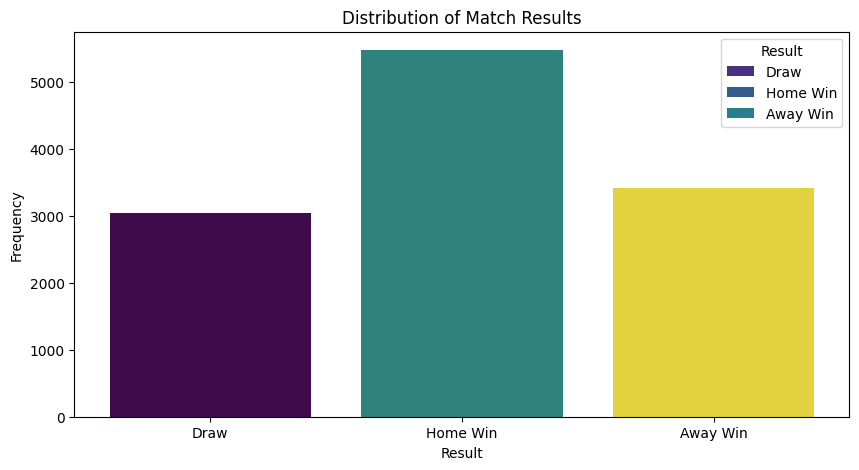

In [15]:
# Distribution of Match Results
print(df['Result'].value_counts())
# Distribution of match results with legend
result_counts = df['Result'].value_counts().reset_index()
result_counts.columns = ['Result', 'Frequency']

# Assigning the x variable to hue and setting legend=False
plt.figure(figsize=(10, 5))
sns.barplot(x='Result', y='Frequency', data=result_counts, hue='Result', palette='viridis', dodge=False, legend=False)
plt.title('Distribution of Match Results')
plt.xlabel('Result')
plt.ylabel('Frequency')
plt.xticks([0, 1, 2], ['Draw', 'Home Win', 'Away Win'])  # Custom x-axis labels
# Adding legend
legend_labels = ['Draw', 'Home Win', 'Away Win']
for i, label in enumerate(legend_labels):
    plt.bar(0, 0, color=sns.color_palette('viridis')[i], label=label)
plt.legend(title='Result')
plt.show()

In [16]:
# Count of unique teams in the league
unique_home_teams = df['Home_Team'].unique()
unique_away_teams = df['Away_Team'].unique()

# Combine both lists to find the total number of unique teams
unique_teams = set(unique_home_teams).union(set(unique_away_teams))
print(f"Total unique teams that have played in the league: {len(unique_teams)}")

Total unique teams that have played in the league: 51


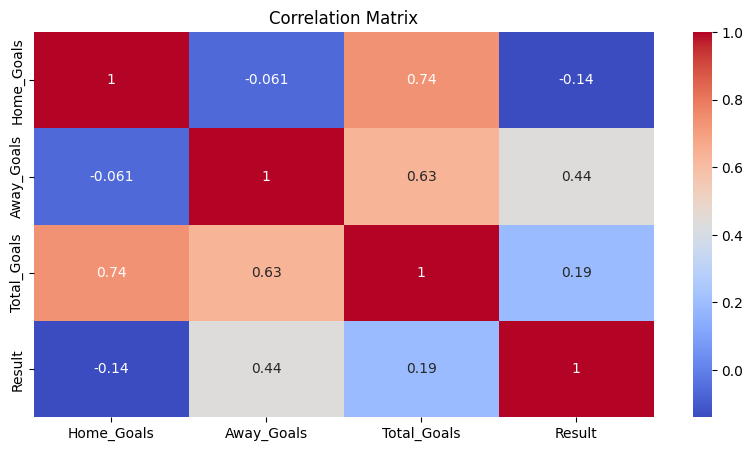

In [17]:
# Correlation matrix between key variables such as Home_Goals, Away_Goals, Total_Goals, and Result
corr_matrix = df[['Home_Goals', 'Away_Goals', 'Total_Goals', 'Result']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

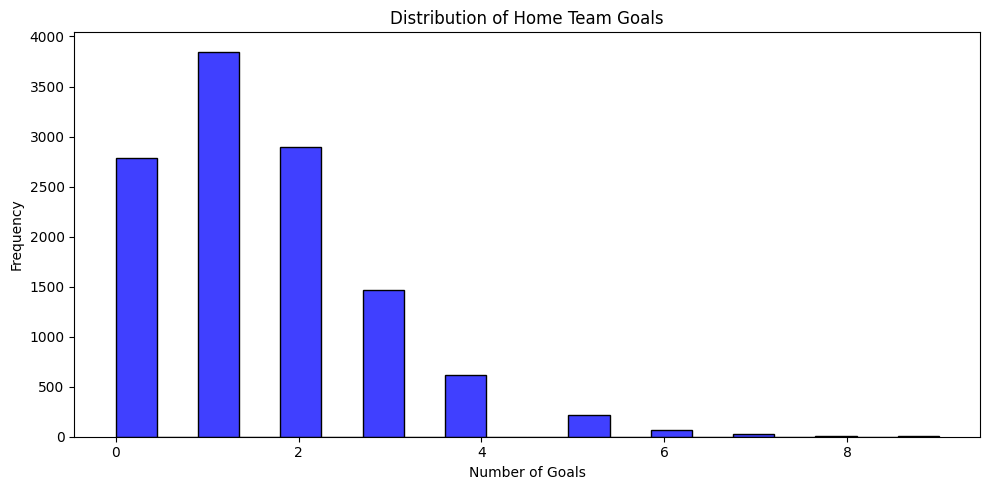

In [18]:
# Home Goals Distribution
plt.figure(figsize=(10, 5))
# Home team goals
sns.histplot(df['Home_Goals'], bins=20, color='blue')
plt.title('Distribution of Home Team Goals')
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

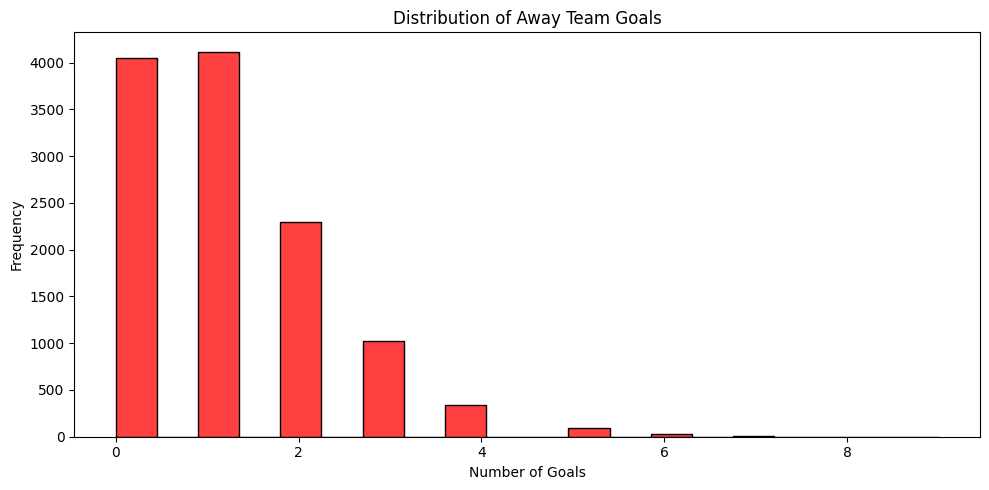

In [19]:
# Away Goals Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Away_Goals'], bins=20, color='red')
plt.title('Distribution of Away Team Goals')
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

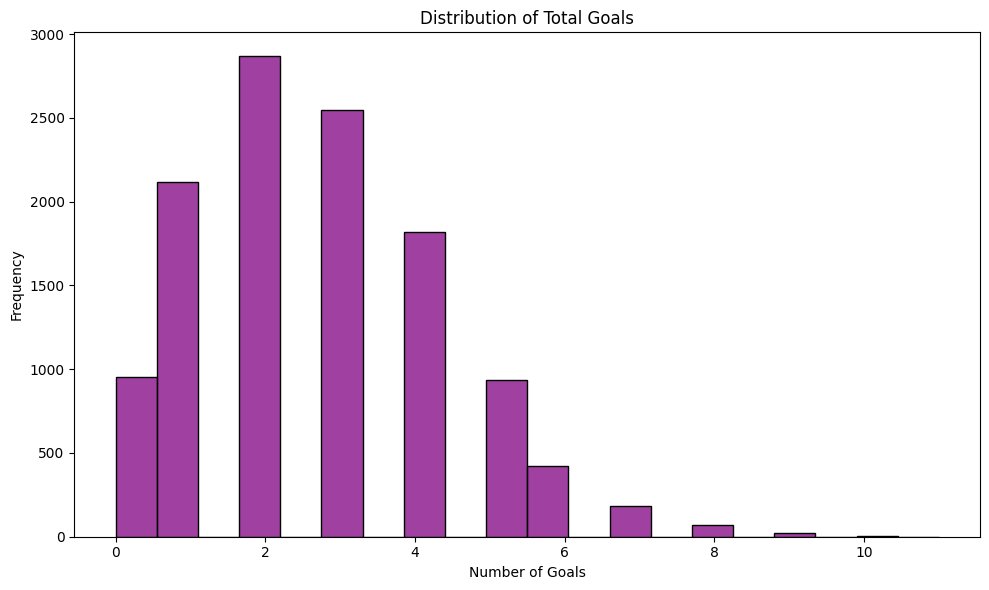

In [20]:
# Total Goals Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Total_Goals'], bins=20, color='purple')
plt.title('Distribution of Total Goals')
plt.xlabel('Number of Goals')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

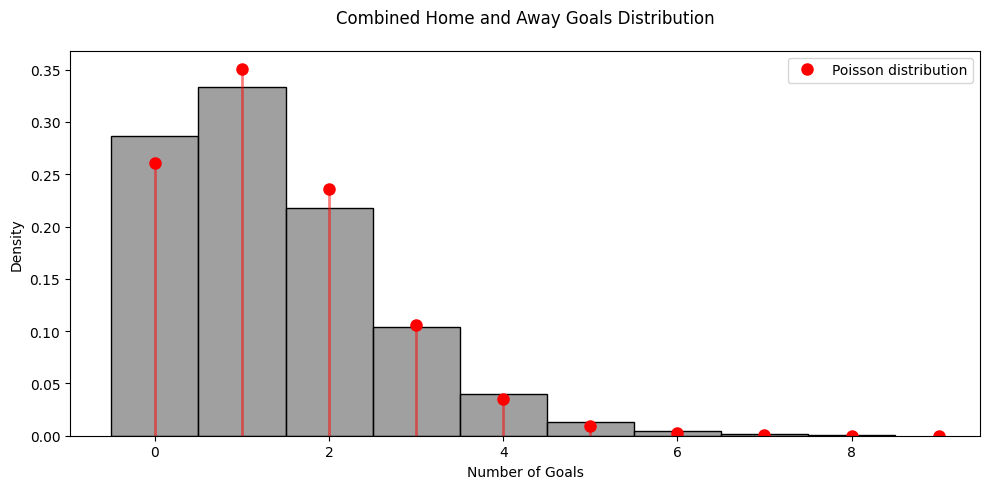

In [21]:
# Combine home and away goals into a single series for overall goal distribution
all_goals = pd.concat([df['Home_Goals'], df['Away_Goals']])
# Calculate the mean number of goals
mean_goals = all_goals.mean()
# Overall goal distribution using combined Home and Away Goals
plt.figure(figsize=(10, 5))
sns.histplot(all_goals, bins=np.arange(0, all_goals.max() + 1) - 0.5, kde=False, color='gray', stat='density')
x = np.arange(0, all_goals.max() + 1)
plt.plot(x, poisson.pmf(x, mean_goals), 'ro', ms=8, label='Poisson distribution')
plt.vlines(x, 0, poisson.pmf(x, mean_goals), colors='red', lw=2, alpha=0.5)
plt.title('Combined Home and Away Goals Distribution', pad=20)
plt.xlabel('Number of Goals')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

The close alignment between the actual goal distribution and the Poisson model suggests that a Poisson distribution is a suitable model for predicting football match goals. 

This justifies the use of Poisson regression or related models in forecasting and analyzing match outcomes.

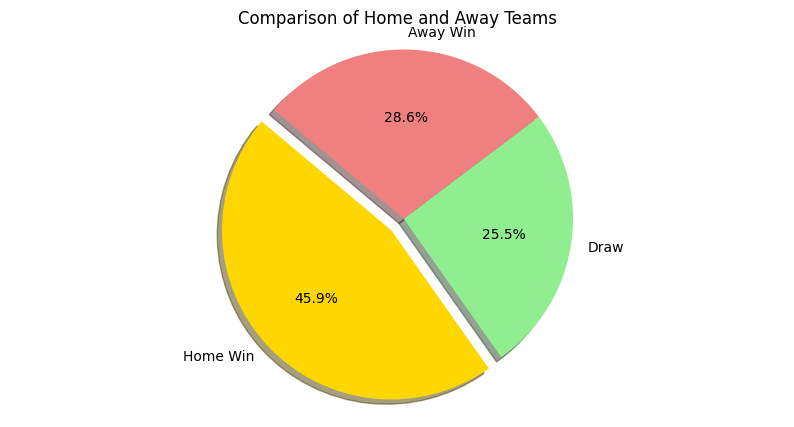

In [22]:
# Comparison of Home Team and Away Team
home_wins = df[df['Result'] == 1].shape[0]
draws = df[df['Result'] == 0].shape[0]
away_wins = df[df['Result'] == 2].shape[0]
labels = ['Home Win', 'Draw', 'Away Win']
sizes = [home_wins, draws, away_wins]
colors = ['gold', 'lightgreen', 'lightcoral']
explode = (0.1, 0, 0)  # Highlight the home win
plt.figure(figsize=(10, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Comparison of Home and Away Teams')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# Display the plot
plt.show()

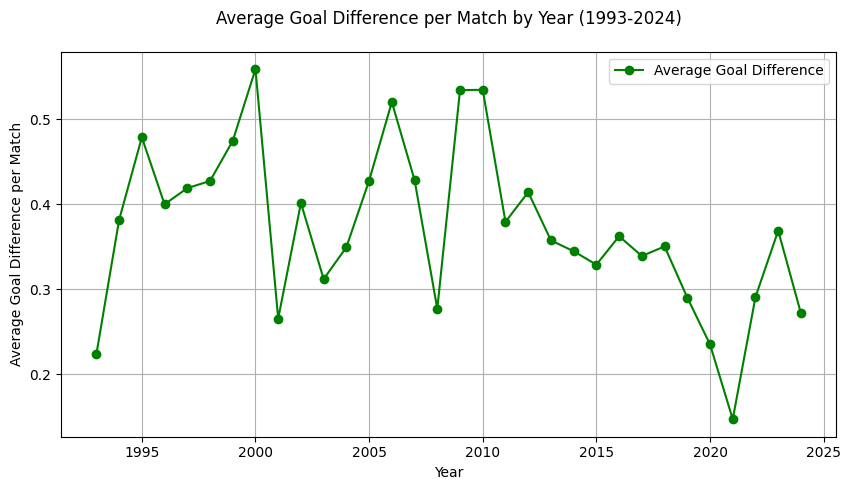

In [23]:
plot_match_based_goal_difference(df, 'Average Goal Difference per Match by Year (1993-2024)')

In [24]:
# t-test to determine if the goal advantage for home teams is statistically significant
home_goals = df['Home_Goals']
away_goals = df['Away_Goals']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(home_goals, away_goals)

# Print the results with scientific notation for the p-value
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.2e}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("The difference in goals between home and away teams is statistically significant.")
else:
    print("The difference in goals between home and away teams is not statistically significant.")

T-statistic: 23.62
P-value: 5.46e-122
The difference in goals between home and away teams is statistically significant.


C:\Users\manuz\AppData\Local\Temp\ipykernel_19228\566051495.py:6: DeprecationWarning: Please import `ttest_ind` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  t_stat, p_value = stats.ttest_ind(home_goals, away_goals)


This suggests that home teams generally have a significant advantage in terms of goal scoring.

All Scores and Counts:
 {'1-1': 1358, '1-0': 1249, '2-1': 1034, '2-0': 973, '0-0': 951, '0-1': 871, '1-2': 747, '2-2': 596, '3-1': 541, '0-2': 536, '3-0': 503, '1-3': 337, '0-3': 262, '3-2': 261, '4-0': 228, '2-3': 219, '4-1': 203, '3-3': 126, '0-4': 118, '1-4': 114, '4-2': 109, '5-0': 103, '5-1': 71, '4-3': 59, '2-4': 55, '0-5': 34, '3-4': 32, '1-5': 29, '6-1': 26, '5-2': 25, '6-0': 23, '2-5': 17, '4-4': 17, '5-3': 13, '6-2': 12, '1-6': 12, '0-6': 12, '7-1': 11, '7-0': 9, '8-0': 5, '2-6': 5, '7-2': 5, '6-3': 5, '3-5': 4, '9-0': 3, '4-5': 3, '5-4': 3, '3-6': 2, '1-7': 2, '7-3': 1, '0-7': 1, '0-9': 1, '5-5': 1, '8-1': 1, '8-2': 1, '9-1': 1, '6-4': 1, '7-4': 1, '1-8': 1, '0-8': 1} 



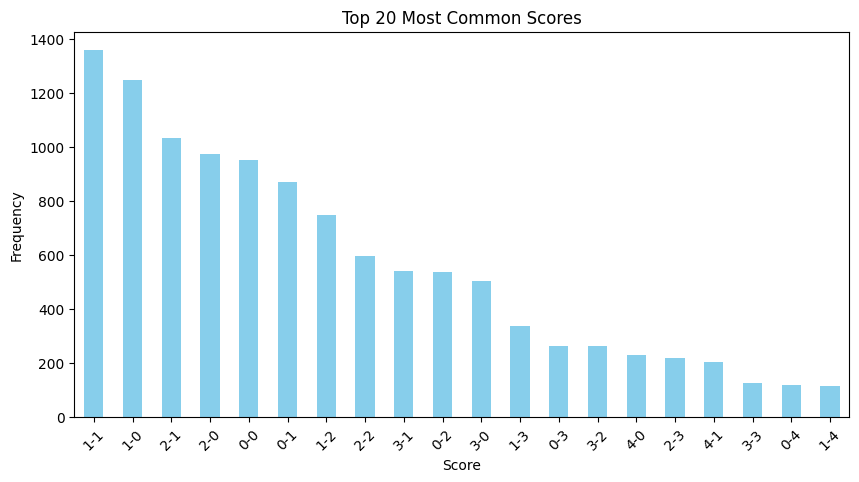

In [25]:
# Find and Plot Common Scores in a Dataset
find_and_plot_common_scores(df)

# Model - Time Dependent + Home Advantage

In [26]:
# Getting Model and Trace
model_info_time_dep_non_centered_model, trace_info_time_dep_non_centered_model = informative_time_dependent_non_centered_model(df_18_24)

c:\Users\manuz\Desktop\Adm\Projects\HierarchicalBayesianEPL\.venv\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1030: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(


Finished [100%]: Average Loss = 6,820.8


<Figure size 1000x400 with 0 Axes>

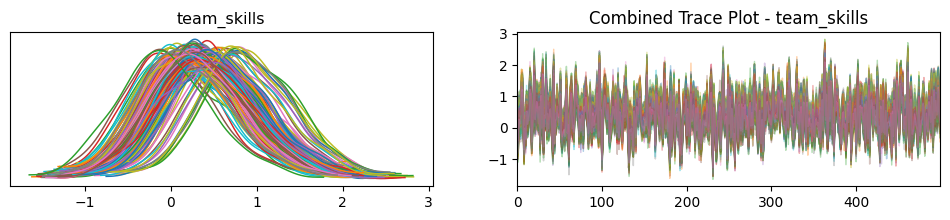

<Figure size 1000x400 with 0 Axes>

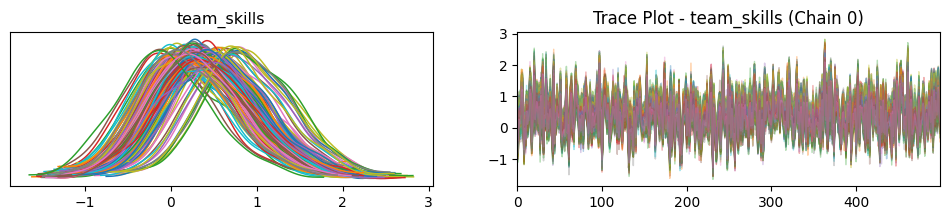

<Figure size 1000x400 with 0 Axes>

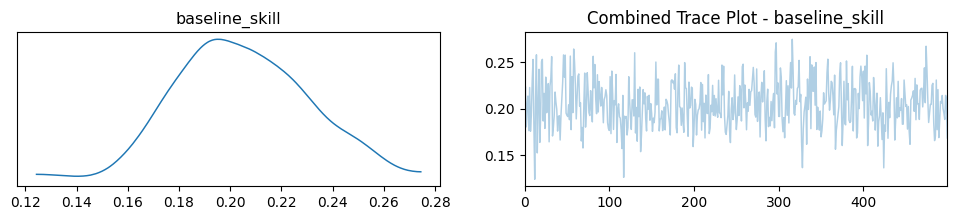

<Figure size 1000x400 with 0 Axes>

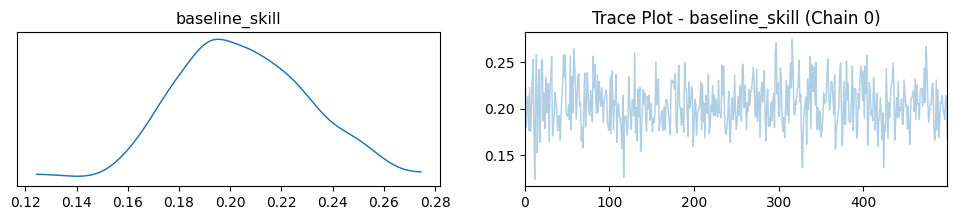

<Figure size 1000x400 with 0 Axes>

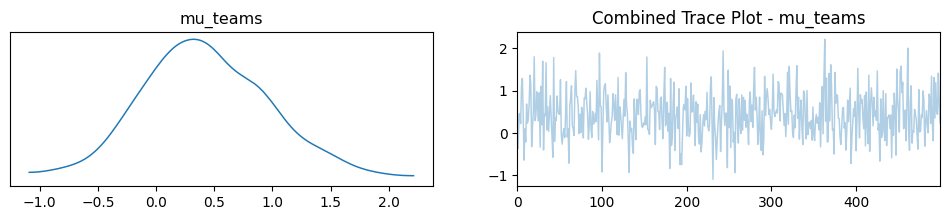

<Figure size 1000x400 with 0 Axes>

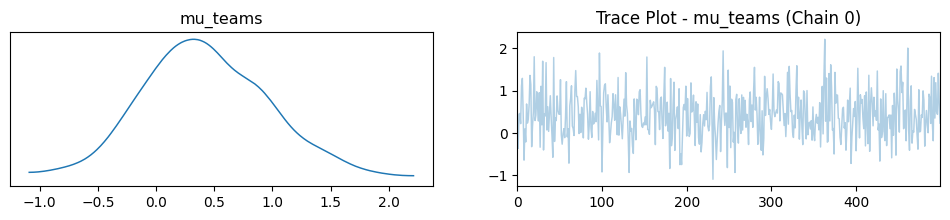

<Figure size 1000x400 with 0 Axes>

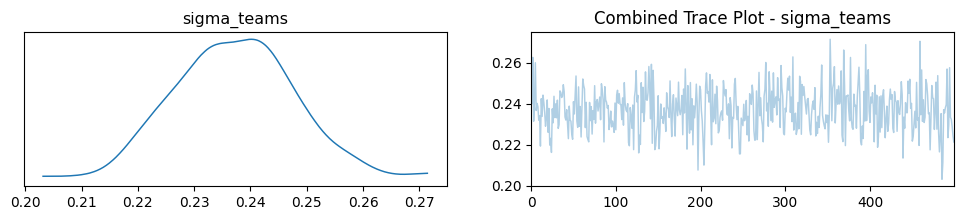

<Figure size 1000x400 with 0 Axes>

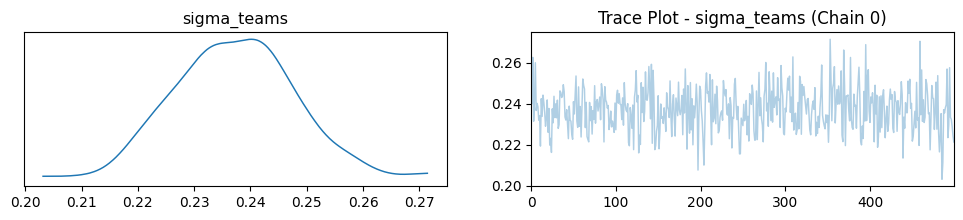

In [27]:
plot_trace_combined(trace_info_time_dep_non_centered_model, 'team_skills')
plot_trace_by_chain(trace_info_time_dep_non_centered_model, 'team_skills')
plot_trace_combined(trace_info_time_dep_non_centered_model, 'baseline_skill')
plot_trace_by_chain(trace_info_time_dep_non_centered_model, 'baseline_skill')
plot_trace_combined(trace_info_time_dep_non_centered_model, 'mu_teams')
plot_trace_by_chain(trace_info_time_dep_non_centered_model, 'mu_teams')
plot_trace_combined(trace_info_time_dep_non_centered_model, 'sigma_teams')
plot_trace_by_chain(trace_info_time_dep_non_centered_model, 'sigma_teams')
save_arviz_plots(trace_info_time_dep_non_centered_model, parameters=['team_skills', 'baseline_skill', 'home_advantage', 'mu_teams', 'sigma_teams'])

Sampling: [away_goals_observed, home_goals_observed]


c:\Users\manuz\Desktop\Adm\Projects\HierarchicalBayesianEPL\.venv\lib\site-packages\arviz\plots\ppcplot.py:268: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
c:\Users\manuz\Desktop\Adm\Projects\HierarchicalBayesianEPL\.venv\lib\site-packages\arviz\plots\ppcplot.py:272: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Figure size 1200x600 with 0 Axes>

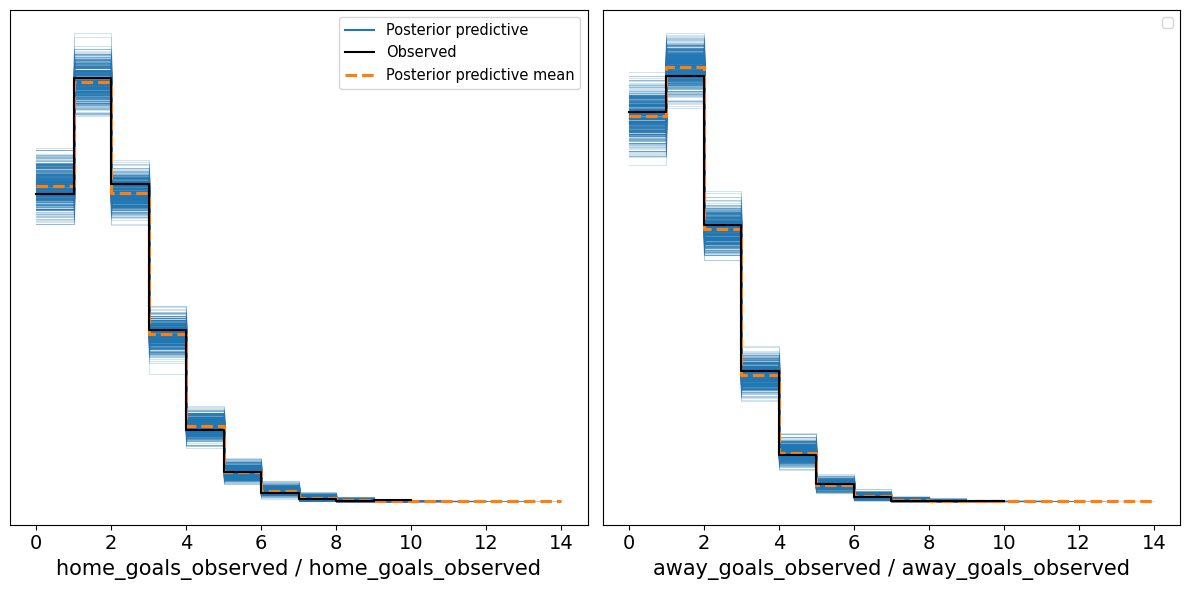

Home_Goals - MAE: 0.9408684210526315, RMSE: 1.1961701838667982
Away_Goals - MAE: 0.888121052631579, RMSE: 1.1308827463379714


In [28]:
# Calculating error metrics (MAE and RMSE)
ppc_time_dep_informative_non_centered_model =save_ppc_plot(model_info_time_dep_non_centered_model,
                                                            trace_info_time_dep_non_centered_model, "ppc_time_dep_informative_non_centered_model.png")
# Home teams goals
home_mae, home_rmse = calculate_errors(ppc_time_dep_informative_non_centered_model, df_18_24, 'Home_Goals', 'home_goals_observed')

# Away Teams  goals
away_mae, away_rmse = calculate_errors(ppc_time_dep_informative_non_centered_model, df_18_24, 'Away_Goals', 'away_goals_observed')

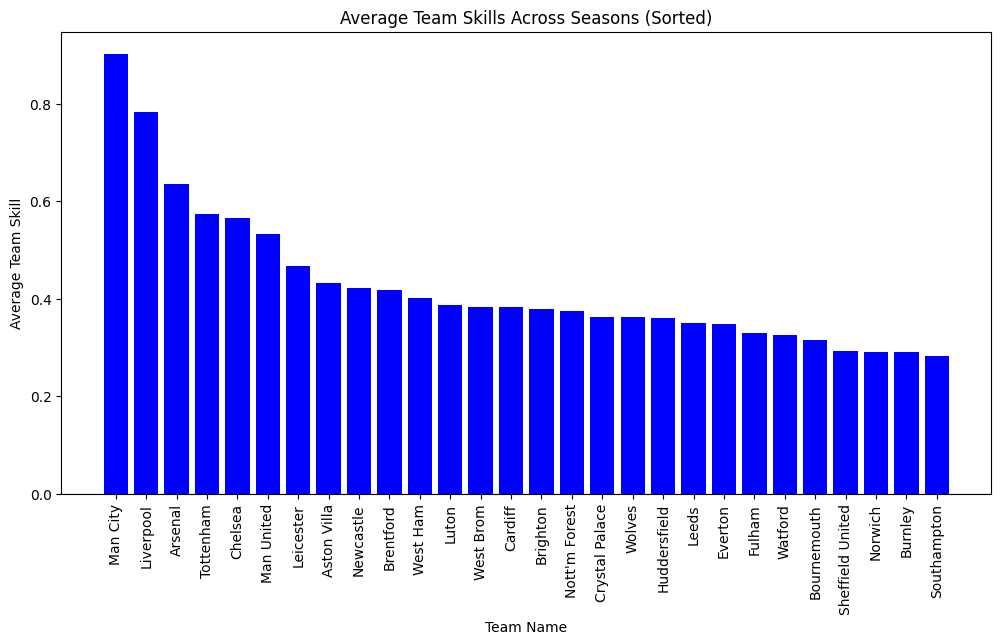

In [29]:
# Visualize team skills across all seasons
visualize_team_skills_time_dependent(df_18_24, trace_info_time_dep_non_centered_model, filename="info_time_dep_non_centered_team_skill.png")

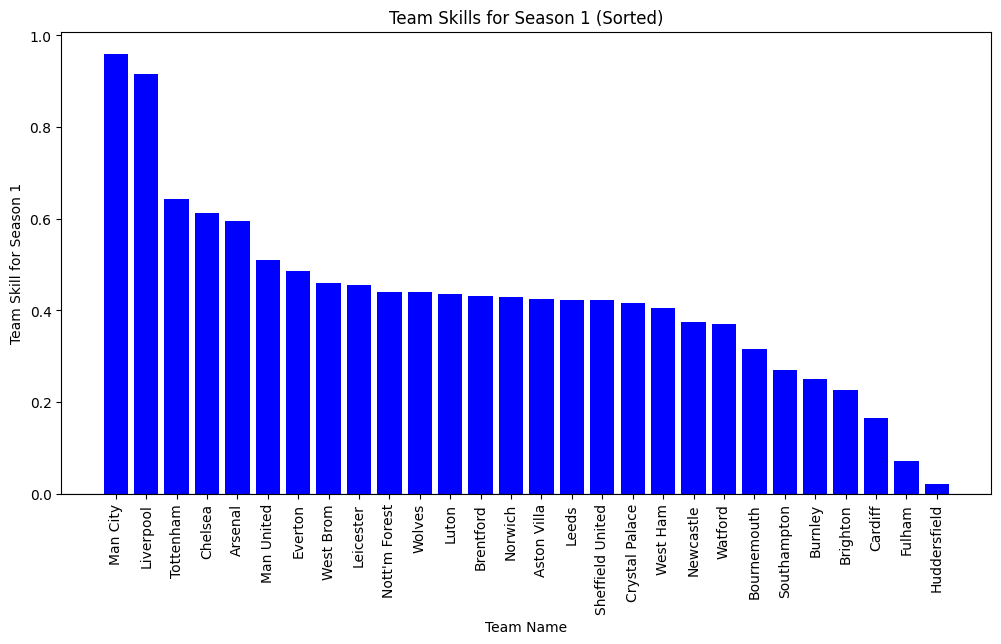

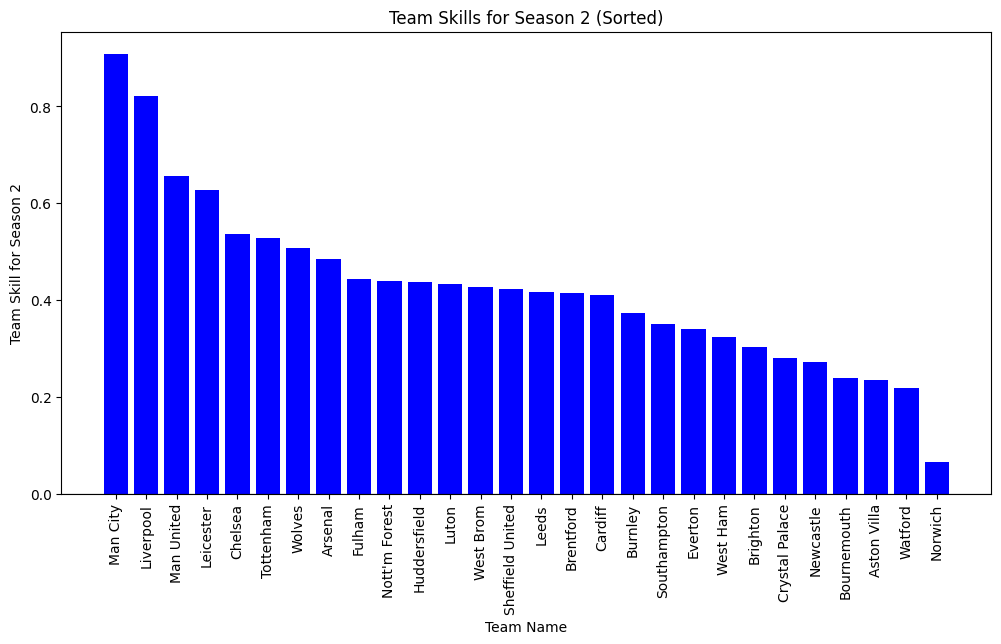

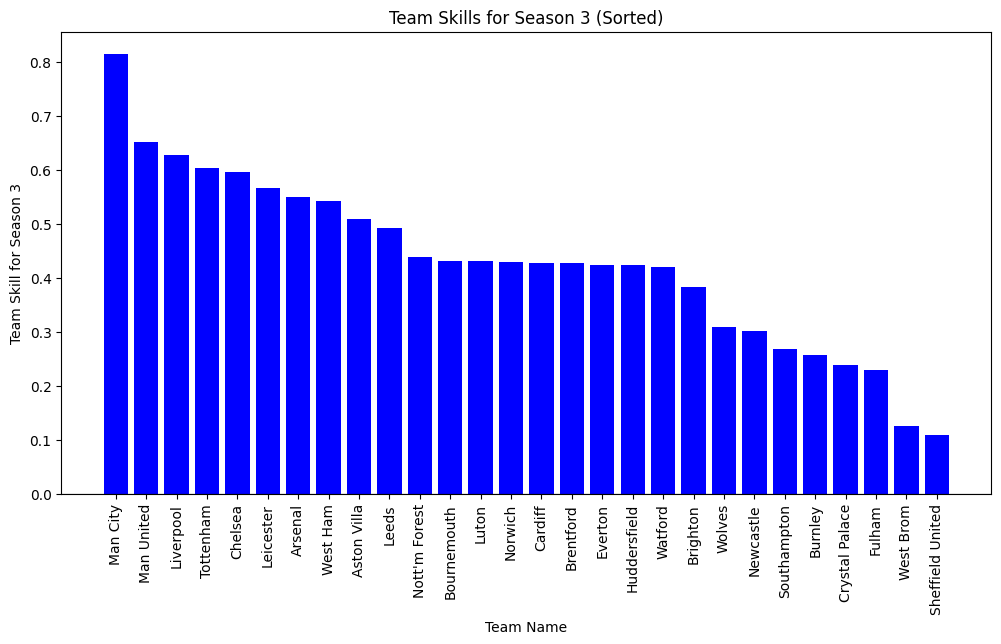

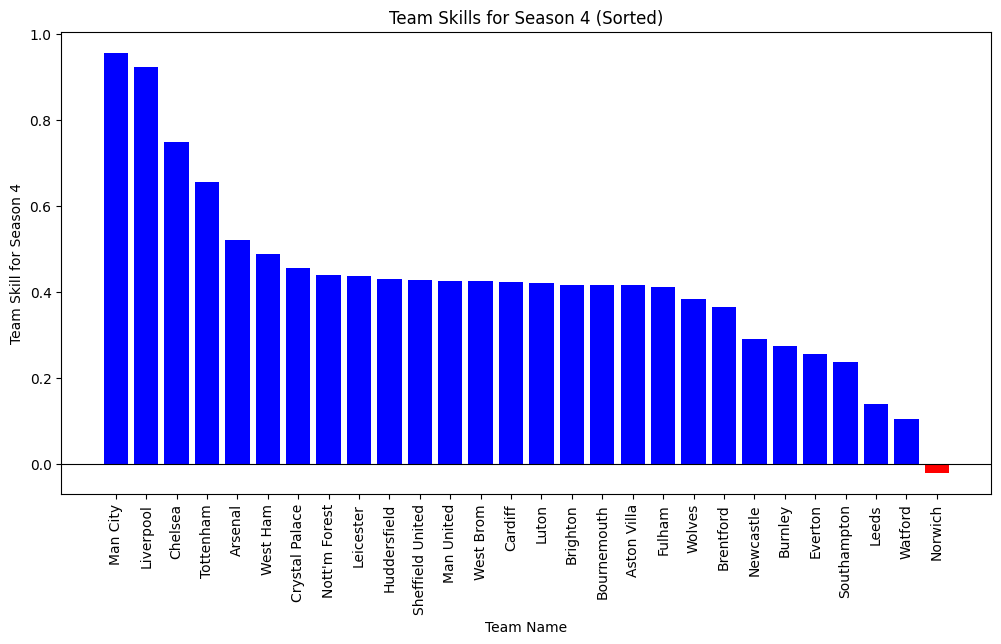

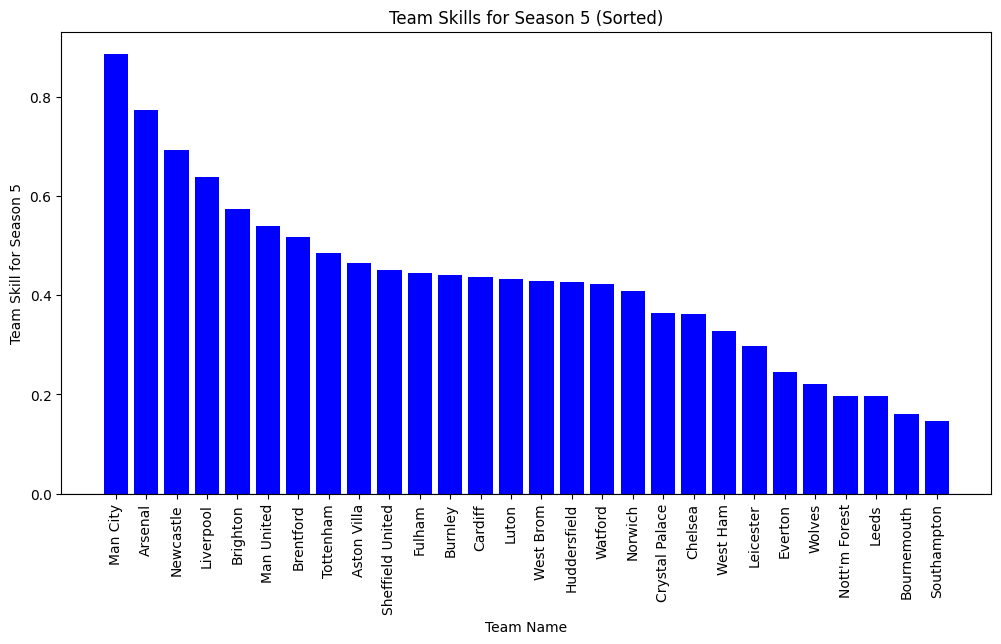

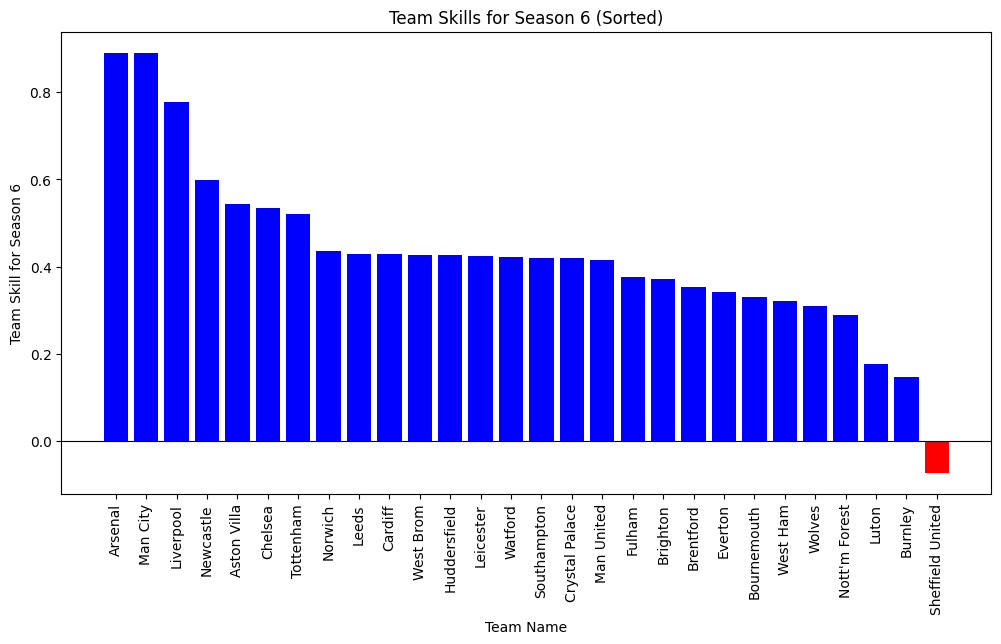

In [30]:
# Visualize team skills for each season
visualize_team_skills_seasonal(df_18_24, trace_info_time_dep_non_centered_model, filename_prefix="info_time_dep_non_centered_season_skills")

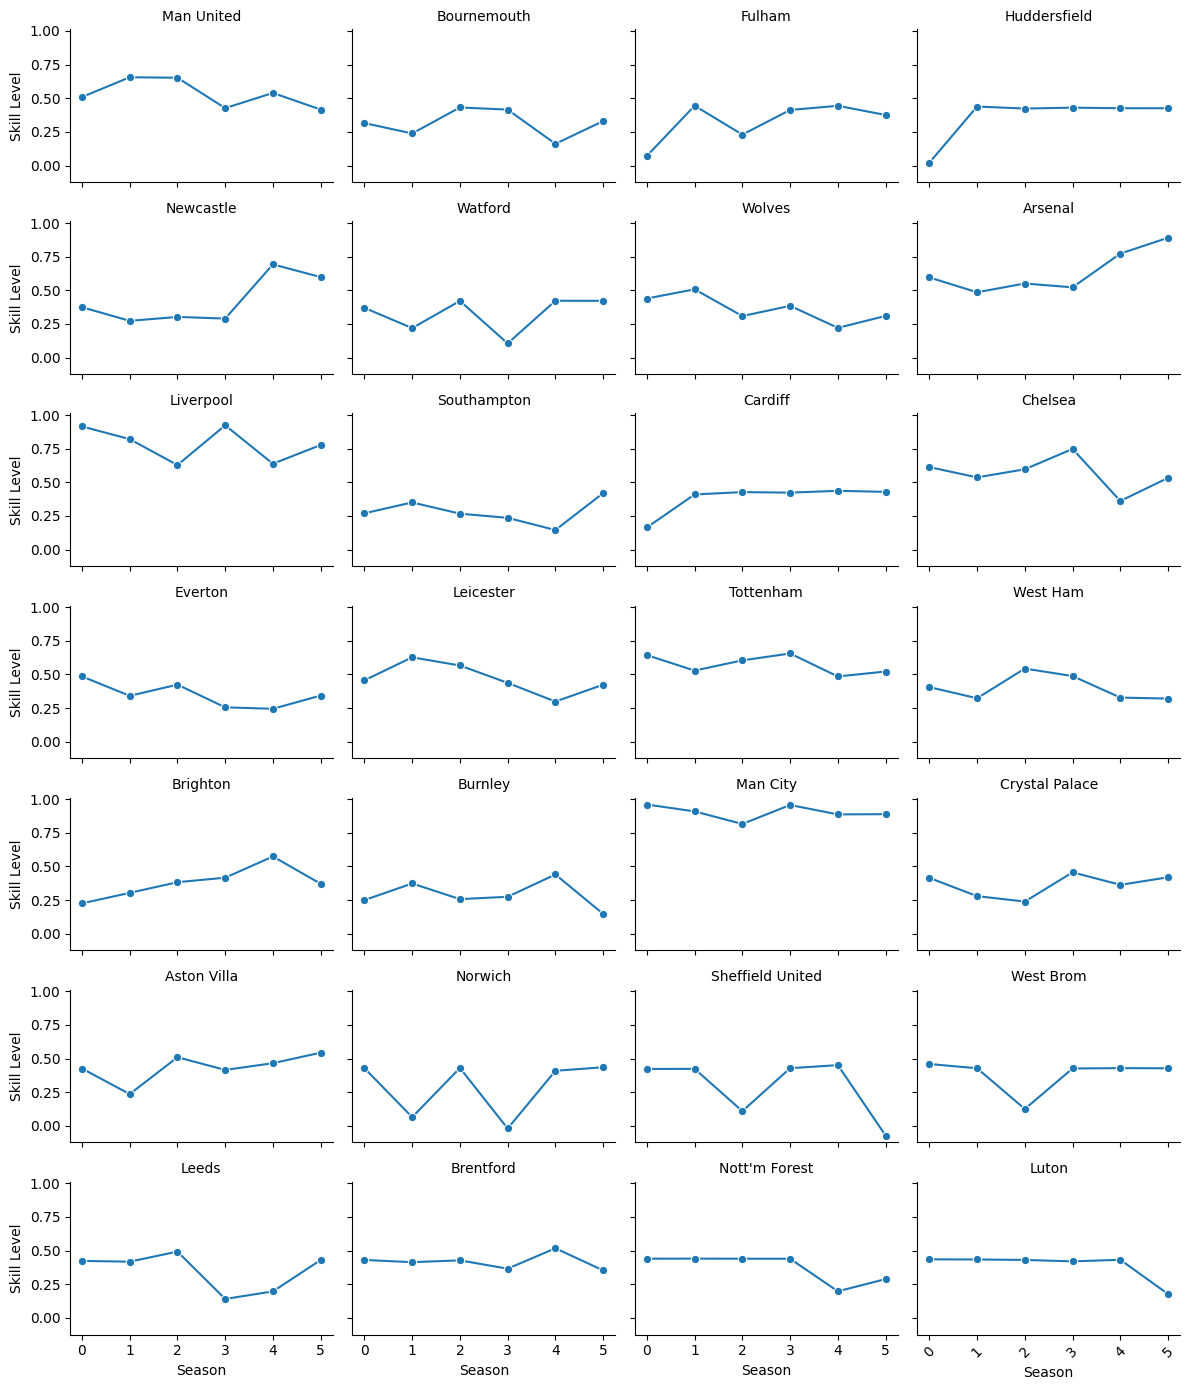

In [31]:
# Visualizes how team skills evolve over multiple seasons
visualize_team_skills_facets(df_18_24, trace_info_time_dep_non_centered_model)

# Use Cases

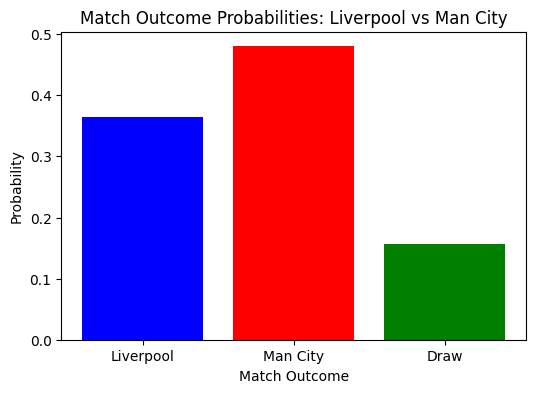

{'Liverpool Win Probability': 0.364,
 'Man City Win Probability': 0.48,
 'Draw Probability': 0.156}

In [33]:
# Match Outcome Predictions
simulate_match_outcome_time_dependent( 'Liverpool', 'Man City',5, df_18_24,trace_info_time_dep_non_centered_model)


Total Simulated Matches:  500
Man City vs Arsenal       1 - 0
Score Occurrences:        62
Score Probability:        0.1240 (12.40%)



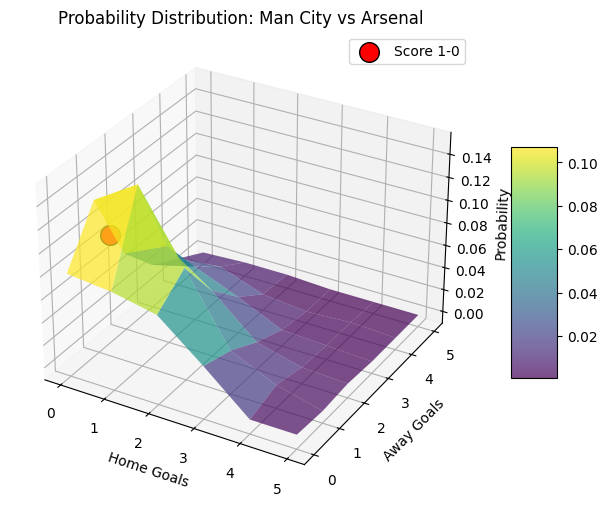

In [ ]:
# Calculating Score Probabilities
calculate_and_visualize_score_probability_time_dependent('Man City', 'Arsenal', 1, 0, 5, df_18_24, trace_info_time_dep_non_centered_model)

In [38]:
# league table standings
league_table_time_dependent = simulate_league_table_with_time_dependent(df_18_24, trace_info_time_dep_non_centered_model, 5)
league_table_time_dependent

,Position 1,Position 2,Position 3,Position 4,Position 5,Position 6,Position 7,Position 8,Position 9,Position 10,...,Position 19,Position 20,Position 21,Position 22,Position 23,Position 24,Position 25,Position 26,Position 27,Position 28
Man United,0.000,0.000,0.004,0.018,0.064,0.120,0.114,0.094,0.118,0.126,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Bournemouth,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.100,0.090,0.032,0.006,0.000,0.000,0.000,0.000,0.000,0.000
Fulham,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.088,0.042,0.006,0.002,0.000,0.000,0.000,0.000,0.000,0.000
Huddersfield,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.004,0.024,0.058,0.126,0.192,0.226,0.204,0.166
Newcastle,0.000,0.018,0.110,0.354,0.208,0.132,0.076,0.046,0.024,0.012,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Watford,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.002,0.000,...,0.102,0.126,0.162,0.082,0.046,0.022,0.010,0.004,0.004,0.002
Wolves,0.000,0.000,0.000,0.002,0.006,0.026,0.036,0.054,0.064,0.090,...,0.004,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Arsenal,0.444,0.352,0.172,0.018,0.012,0.002,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Liverpool,0.100,0.216,0.478,0.142,0.040,0.016,0.004,0.004,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Southampton,0.000,0.008,0.014,0.046,0.042,0.052,0.048,0.046,0.036,0.048,...,0.048,0.040,0.036,0.010,0.008,0.004,0.002,0.000,0.000,0.000


In [40]:
display_average_rank_league_table(league_table_time_dependent)

            Average Rank League Table             

   Position             Team Average Rank
 Position 1         Man City         1.74
 Position 2          Arsenal         1.81
 Position 3        Liverpool         2.89
 Position 4        Newcastle         5.09
 Position 5          Chelsea         6.44
 Position 6        Tottenham         6.66
 Position 7   Crystal Palace         9.20
 Position 8       Man United         9.22
 Position 9      Aston Villa         9.71
Position 10         Brighton        10.41
Position 11          Everton        11.22
Position 12         West Ham        11.80
Position 13           Wolves        12.08
Position 14        Leicester        12.41
Position 15      Southampton        12.55
Position 16           Fulham        16.50
Position 17      Bournemouth        17.17
Position 18          Burnley        17.93
Position 19          Watford        18.85
Position 20            Leeds        18.95
Position 21        Brentford        19.87
Position 22          Nor

In [42]:
get_team_position_probability(league_table_time_dependent, 'Man City', 1)

0.454

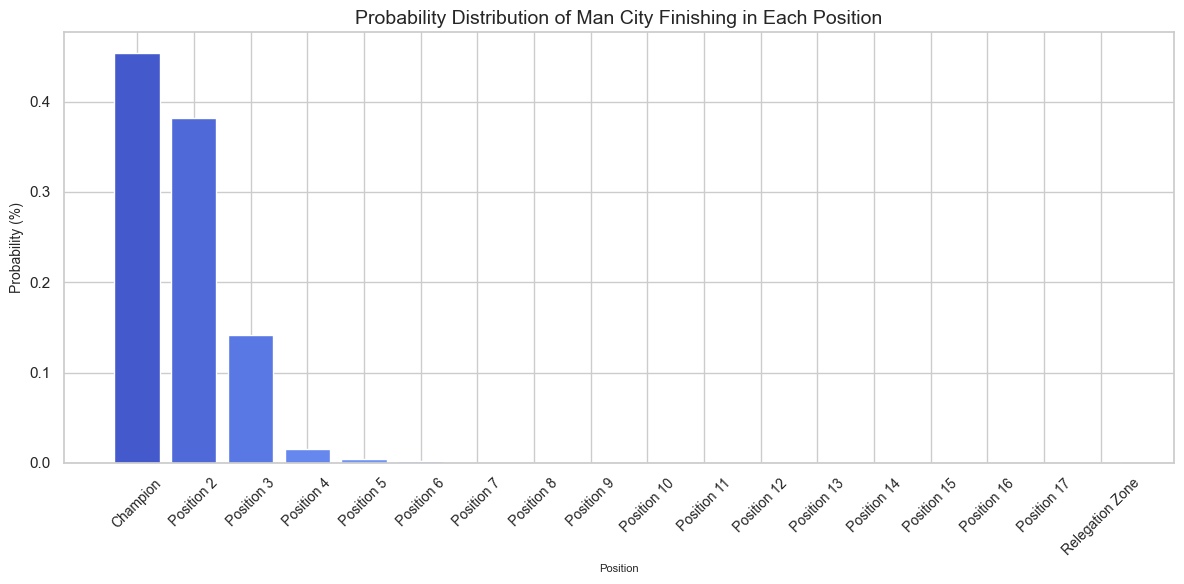

In [44]:
visualize_team_position_probabilities(league_table_time_dependent, 'Man City')

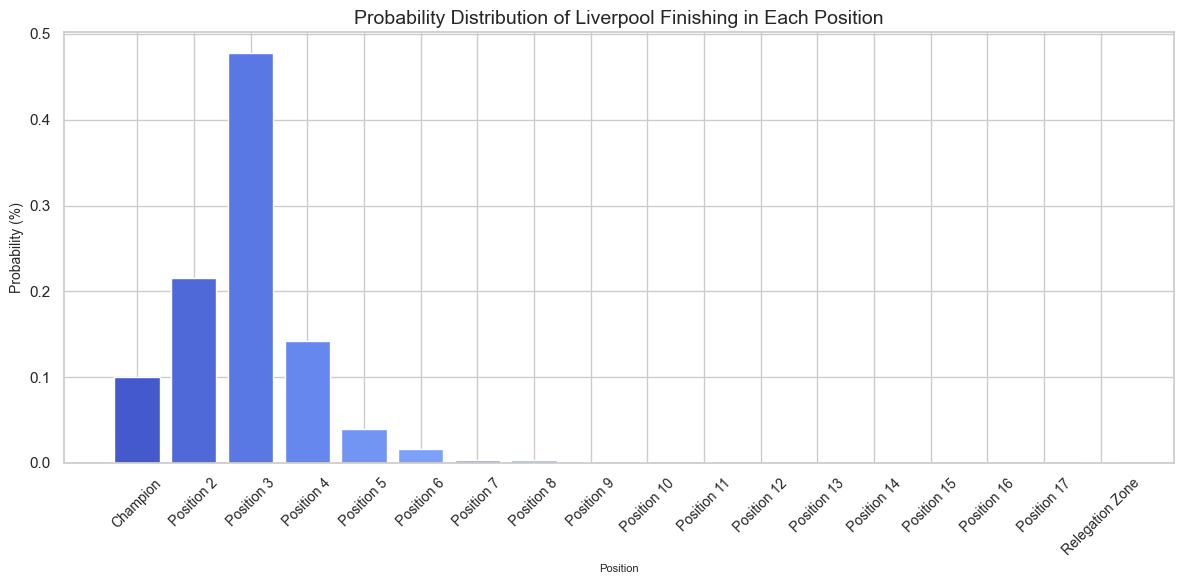

In [45]:
visualize_team_position_probabilities(league_table_time_dependent, 'Liverpool')